# **0. Library Imports**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from indo_normalizer import Normalizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# **1. Dataset Imports**

In [24]:
df =  pd.read_csv('data/tweet.csv') 

#drop kolom unnamed
drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
if drop_cols:
    df = df.drop(columns=drop_cols)

n_rows, n_cols = df.shape
null_counts = df.isna().sum()
dupes = df.duplicated().sum()

print("n_rows:", n_rows, "| n_cols:", n_cols)
print("columns:", list(df.columns))
print("null_counts:\n", null_counts)
print("duplicate_rows:", dupes)

n_rows: 1815 | n_cols: 2
columns: ['sentimen', 'tweet']
null_counts:
 sentimen    0
tweet       0
dtype: int64
duplicate_rows: 0


# **2. Exploratory Data Analysis**

## 2.1. Cek distribusi kelas sentimen

In [25]:
cls_counts = df["sentimen"].value_counts().sort_index()
cls_ratio = (cls_counts/len(df)).round(4)
print(pd.DataFrame({"count": cls_counts, "ratio": cls_ratio}))

          count   ratio
sentimen               
negatif     596  0.3284
netral      607  0.3344
positif     612  0.3372


Kelas target seimbang sehingga tidak memerlukan penanganan oversampling atau undersampling.

## 2.2. Panjang teks

In [26]:
length = df["tweet"].astype(str).str.len()
stats_len = {
    "mean": round(length.mean(), 2),
    "median": float(length.median()),
    "min": int(length.min()),
    "p10": float(length.quantile(0.10)),
    "p90": float(length.quantile(0.90)),
    "max": int(length.max()),
}
stats_len

{'mean': np.float64(194.67),
 'median': 200.0,
 'min': 27,
 'p10': 90.0,
 'p90': 280.0,
 'max': 668}

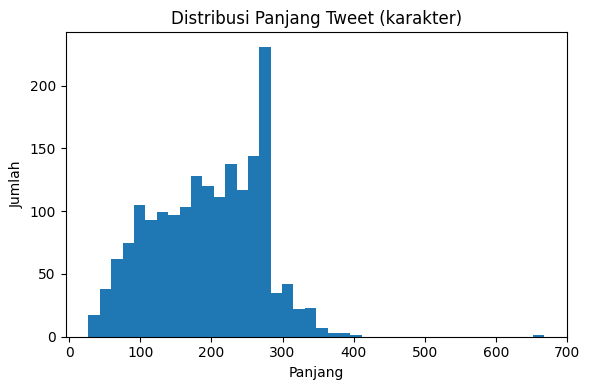

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13208\3566241196.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_class, labels=sorted(df["sentimen"].unique()), showfliers=False)


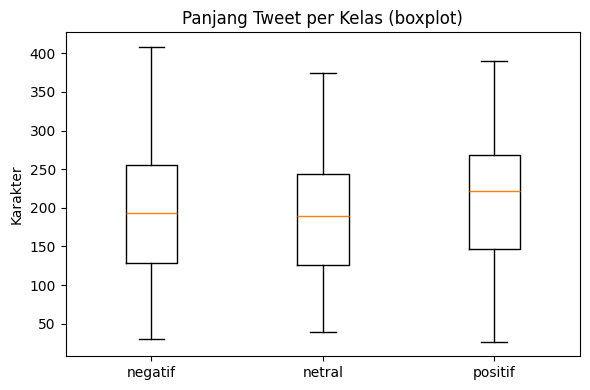

In [9]:
# Histogram panjang karakter
plt.figure(figsize=(6,4))
plt.hist(length, bins=40)
plt.title("Distribusi Panjang Tweet (karakter)")
plt.xlabel("Panjang")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

# Boxplot panjang per kelas
plt.figure(figsize=(6,4))
data_per_class = [length[df["sentimen"]==k] for k in sorted(df["sentimen"].unique())]
plt.boxplot(data_per_class, labels=sorted(df["sentimen"].unique()), showfliers=False)
plt.title("Panjang Tweet per Kelas (boxplot)")
plt.ylabel("Karakter")
plt.tight_layout()
plt.show()

Tweet cenderung menengah hingga panjang dengan ekor kanan. TF-IDF word/char n-gram relevan dan perlu pembatasan kosakata (min_df, max_df) agar tidak terlalu banyak mengandung kata-kata noise.

## 2.3. Pola Entitas Data Twitter

In [27]:
s = df["tweet"].astype(str)

has_url = s.str.contains(r"http\S+|www\.\S+", regex=True)
has_mention = s.str.contains(r"@\w+", regex=True)
has_hashtag = s.str.contains(r"#\w+", regex=True)
starts_with_rt = s.str.lower().str.strip().str.startswith("rt")

stats_entities = {
    "has_url_pct": round(has_url.mean()*100, 2),
    "has_mention_pct": round(has_mention.mean()*100, 2),
    "has_hashtag_pct": round(has_hashtag.mean()*100, 2),
    "starts_with_rt_pct": round(starts_with_rt.mean()*100, 2),
}
stats_entities

{'has_url_pct': np.float64(25.73),
 'has_mention_pct': np.float64(24.63),
 'has_hashtag_pct': np.float64(30.36),
 'starts_with_rt_pct': np.float64(0.22)}

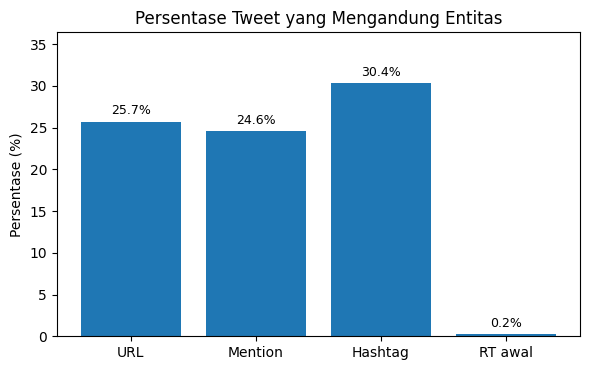

In [28]:
# Bar chart persentase entitas
labels = ["URL","Mention","Hashtag","RT awal"]
values = [stats_entities["has_url_pct"], stats_entities["has_mention_pct"],
          stats_entities["has_hashtag_pct"], stats_entities["starts_with_rt_pct"]]
plt.figure(figsize=(6,3.8))
bars = plt.bar(labels, values)
plt.title("Persentase Tweet yang Mengandung Entitas")
plt.ylabel("Persentase (%)")
for b,v in zip(bars, values):
    plt.text(b.get_x()+b.get_width()/2, v+0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
plt.ylim(0, max(values)*1.20)
plt.tight_layout()
plt.show()

Proporsi URL/mention/hashtag cukup tinggi. Lakukan masking (URL, USER) agar model tidak overfit ke domain/username.Hashtag perlu dipertahankan dan juga dibuat versi tanpa pagar.

## 2.4. Top Hastag dan Mention

In [29]:
from collections import Counter
import re

# Ekstrak token
counts_hash = Counter()
counts_mention = Counter()
for t in s:
    counts_hash.update(re.findall(r"#\w+", t))
    counts_mention.update(re.findall(r"@\w+", t))

top_hashtag = pd.DataFrame(counts_hash.most_common(15), columns=["token","count"])
top_mention = pd.DataFrame(counts_mention.most_common(15), columns=["token","count"])

print("Top Hashtag:\n", top_hashtag.head(10).to_string(index=False))
print("\nTop Mention:\n", top_mention.head(10).to_string(index=False))

Top Hashtag:
                     token  count
      #PrabowoSalahkanSBY     90
          #PilihOrangBaik     61
          #PilihBajuPutih     60
  #JokowiMenangTotalDebat     55
      #PilihJelasIslamnya     55
#UASdifitnahKejiDanBrutal     34
        #DebatPilpres2019     22
       #TusukPrabowoSandi     21
       #2019GantiPresiden     20
             #YourTurnBro     18

Top Mention:
         token  count
      @jokowi    233
     @prabowo    148
    @sandiuno    108
      @Jokowi     18
@KHMarufAmin_     13
 @SBYudhoyono     10
 @bocahsosmed      8
@sukangetweet      8
 @saaebunglon      8
      @KPU_ID      7


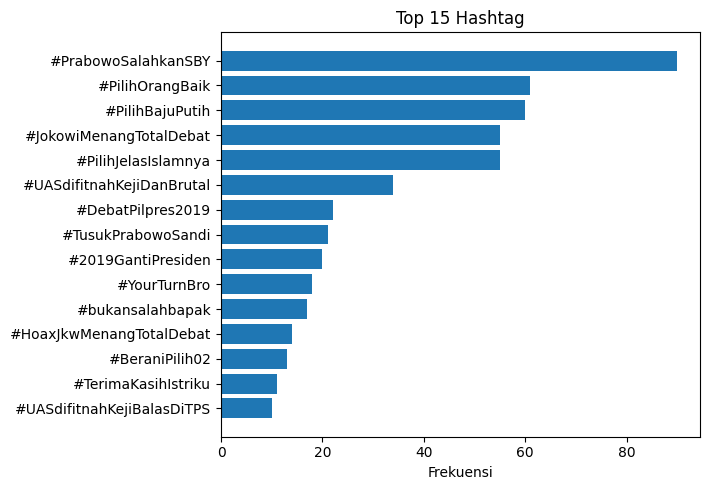

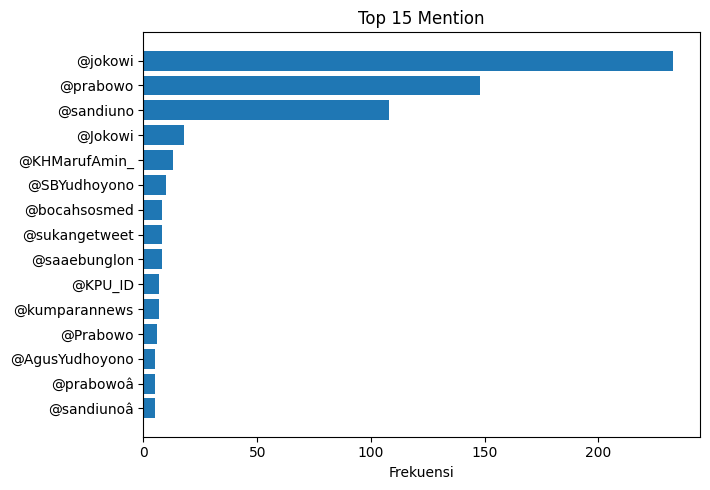

In [30]:
# Visual: barh untuk hashtag
plt.figure(figsize=(7.2,5))
plt.barh(top_hashtag["token"][::-1], top_hashtag["count"][::-1])
plt.title("Top 15 Hashtag")
plt.xlabel("Frekuensi")
plt.tight_layout()
plt.show()

# Visual: barh untuk mention
plt.figure(figsize=(7.2,5))
plt.barh(top_mention["token"][::-1], top_mention["count"][::-1])
plt.title("Top 15 Mention")
plt.xlabel("Frekuensi")
plt.tight_layout()
plt.show()

Topik politik mendominasi. Menjaga hashtag sebagai token spesifik dan menambahkan bentuk tanpa pagar penting untuk menangkap sinyal semantik topik.

## 2.5. Indikator Emosi

In [31]:
# Hitung indikator ekspresif
df["_exclaim"]  = s.str.count("!")
df["_question"] = s.str.count(r"\?")
df["_upper_rt"] = s.apply(lambda x: sum(ch.isupper() for ch in x)/max(1,len(x)))

group_mean = df.groupby("sentimen")[["_exclaim","_question","_upper_rt"]].mean().round(3)
print(group_mean)

          _exclaim  _question  _upper_rt
sentimen                                
negatif      0.248      0.607      0.054
netral       0.051      0.204      0.066
positif      0.160      0.158      0.057


C:\Users\LEGION\AppData\Local\Temp\ipykernel_13208\521942336.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)


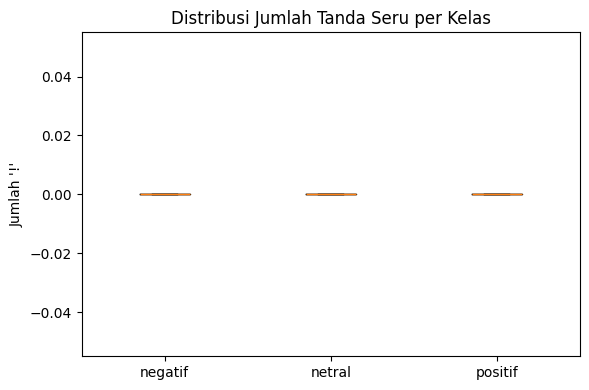

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13208\521942336.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)


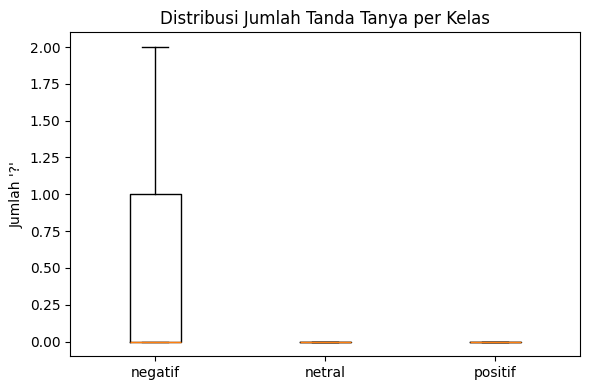

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13208\521942336.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)


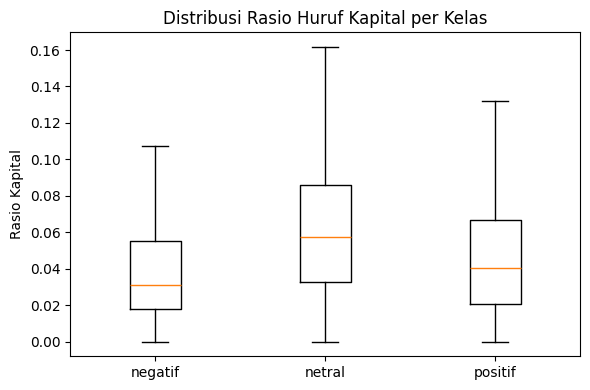

In [32]:
# Boxplot per kelas: tanda seru, tanda tanya, rasio kapital
for col, title, ylabel in [
    ("_exclaim",  "Distribusi Jumlah Tanda Seru per Kelas", "Jumlah '!'"),
    ("_question", "Distribusi Jumlah Tanda Tanya per Kelas", "Jumlah '?'"),
    ("_upper_rt", "Distribusi Rasio Huruf Kapital per Kelas", "Rasio Kapital"),
]:
    plt.figure(figsize=(6,4))
    data = [df.loc[df["sentimen"]==k, col] for k in sorted(df["sentimen"].unique())]
    plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

           _exclaim  _question  _upper_rt
_exclaim       1.00       0.07       0.10
_question      0.07       1.00       0.01
_upper_rt      0.10       0.01       1.00


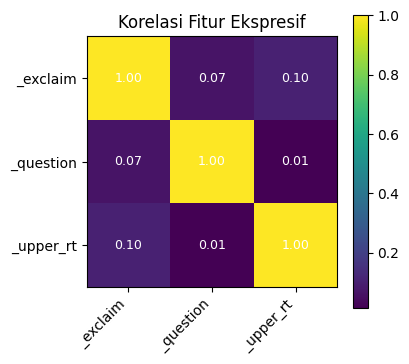

In [33]:
corr = df[["_exclaim","_question","_upper_rt"]].corr()
print(corr.round(2))

plt.figure(figsize=(4.2,3.8))
plt.imshow(corr, interpolation="nearest")
plt.title("Korelasi Fitur Ekspresif")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", color="w", fontsize=9)
plt.colorbar()
plt.tight_layout()
plt.show()

_question kuat pada negatif, _exclaim mendukung positif, sedangkan perbedaan kapital tipis. Fitur ekspresif ini berguna sebagai fitur numerik pelengkap untuk model linear.

# 3. Preprocessing Data

In [39]:
# Text Normalizer
normalizer = Normalizer()

# Daftar stopwords standar dari NLTK
stop_words_standard = set(stopwords.words('indonesian'))

# Daftar kata-kata penting yang TIDAK BOLEH dihapus (pengecualian)
list_stopwords_exceptions = [
    'baik','maju','hebat','berhasil','kuat','setuju','mantap','yakin','terus','murah','adil','lancar',
    'mulia','bangga','cemerlang','senang','keren','optimis','menang','sukses','terbukti','sejahtera',
    'bagus','terbaik','solusi','amanah','jujur','peduli','tegas','pintar',
    'tidak','bukan','jangan','belum','gagal','jelek','susah','mahal','rugi','hancur','lemah','salah',
    'keliru','buruk','parah','bingung','mengecewakan','bohong','kacau','nyungsep','menjerit','terpuruk',
    'turun','kurang','goblok','tolol'
]

list_stopwords_include = [
    'jokowi', 'ekonomi', 'prabowosalahkansby', 'pilihorangbaik', 'pilihbajuputih',
    'pilihjelasislamnya', 'jokowimenangtotaldebat'
]
custom_stopwords_exceptions = set(list_stopwords_exceptions)


# DAFTAR STOPWORD FINAL
final_stop_words = (stop_words_standard - custom_stopwords_exceptions) | set(list_stopwords_include)


# BUAT SATU FUNGSI PREPROCESSING UTAMA

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Hapus karakter non-ASCII (Untuk mengatasi emoji dan mojibake)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+|pic.twitter.com\S+|t.co|S+', '', text, flags=re.MULTILINE)
    # Hapus @username dan #hashtag
    text = re.sub(r'\@|#', '', text)
    # Hapus tanda baca, angka, dan karakter spesial
    text = re.sub(r'[^a-zA-Z\s | ? ]', '', text)
    # Normalize menggunakan indo_normalizer
    normalized_tuple = normalizer.normalize_text(text)
    text = normalized_tuple[0] # Extract the normalized text from the tuple
    
    # Tokenisasi (memecah teks menjadi daftar kata)
    tokens = word_tokenize(text)

    # Menghapus stopwords menggunakan daftar final kita
    tokens = [word for word in tokens if word not in final_stop_words]


    # Menggabungkan kembali token menjadi string
    return ' '.join(tokens)


# --- Eksekusi pada DataFrame ---
df['tweet_pp']   = df['tweet'].apply(preprocess_text)

print('Hasil setelah preprocessing')
print(df[['sentimen','tweet','tweet_pp']].head())

Korpus 'd:\Project\Indonesia AI Bootcamp\Project Sentiment Analysis\.venv\Lib\site-packages\indo_normalizer\corpus\common_words.txt' berhasil dimuat. (18122 kata)
Korpus 'd:\Project\Indonesia AI Bootcamp\Project Sentiment Analysis\.venv\Lib\site-packages\indo_normalizer\corpus\slangs.csv' berhasil dimuat. (1284 pasangan)
Hasil setelah preprocessing
  sentimen                                              tweet  \
0  negatif  Kata @prabowo Indonesia tidak dihargai bangsa ...   
1   netral  Batuan Langka, Tasbih Jokowi Hadiah dari Habib...   
2   netral  Di era Jokowi, ekonomi Indonesia semakin baik....   
3  positif  Bagi Sumatera Selatan, Asian Games berdampak p...   
4  negatif  Negara kita ngutang buat bngun infrastruktur y...   

                                            tweet_pp  
0  prabowo indonesia tidak dihargai bangsa asing ...  
1  batuan langka hadiah habib luthfi seharga mercy ?  
2        era indonesia baik indonesiamaju jokowilagi  
3  sumatera selatan asian games berdam

In [41]:
df.to_csv('data_bersih.csv', index=False, encoding="utf-8-sig")

In [39]:
kamus_df = pd.read_csv('indo_slang_new.csv', names=['ALAY','TIDAK_ALAY'], encoding='latin1')
kamus_df = kamus_df.dropna(subset=['ALAY','TIDAK_ALAY'])
kamus_df['ALAY']       = kamus_df['ALAY'].astype(str).str.strip().str.lower()
kamus_df['TIDAK_ALAY'] = kamus_df['TIDAK_ALAY'].astype(str).str.strip().str.lower()
alay_map = dict(zip(kamus_df['ALAY'].astype(str), kamus_df['TIDAK_ALAY'].astype(str)))

In [51]:
if len(alay_map) > 0:
    pattern = r"\b(" + "|".join(map(re.escape, alay_map.keys())) + r")\b"
    regex_alay = re.compile(pattern)
else:
    regex_alay = None

# 1) Salin kolom agar jejak mentah terjaga
df["tweet_pp"] = df["tweet"].astype(str)

# 2) Hapus 'rt ' di awal (case-insensitive)
df["tweet_pp"] = df["tweet_pp"].str.replace(r"^\s*rt\s+", "", flags=re.IGNORECASE, regex=True)

# 3) Lowercase
df["tweet_pp"] = df["tweet_pp"].str.lower()

# 4) Masking entitas: URL -> 'URL', @mention -> 'USER'
df["tweet_pp"] = df["tweet_pp"].str.replace(r"http\S+|www\.\S+", " URL ", regex=True)
df["tweet_pp"] = df["tweet_pp"].str.replace(r"@\w+", " USER ", regex=True)

# 5) Duplikasi hashtag: '#kata' tetap, plus tambahkan 'kata' (tanpa pagar)
df["tweet_pp"] = df["tweet_pp"].str.replace(r"#(\w+)", r" #\1 \1 ", regex=True)

# 6) Normalisasi slang/alay memakai alay_map (kata utuh saja)
if regex_alay is not None:
    before_cnt = df["tweet_pp"].str.count(regex_alay).sum()
    df["tweet_pp"] = df["tweet_pp"].str.replace(
        regex_alay,
        lambda m: alay_map.get(m.group(1), m.group(1)),
        regex=True
    )
    after_cnt = df["tweet_pp"].str.count(regex_alay).sum()
    replaced_est = int(before_cnt - after_cnt)
else:
    replaced_est = 0
print(f"\n[SUMMARY] Entri kamus: {len(alay_map)} | Perkiraan token slang terganti: {replaced_est}")

# 7) Kompres spasi
df["tweet_pp"] = df["tweet_pp"].str.replace(r"\s+", " ", regex=True).str.strip()

# 8) Tampilkan contoh sebelum vs sesudah
df.head()


[SUMMARY] Entri kamus: 15167 | Perkiraan token slang terganti: 5975


,sentimen,tweet,_exclaim,_question,_upper_rt,tweet_pp
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,1,2,0.030769,kata USER indonesia tidak dihargai bangsa asin...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",0,1,0.139785,"batuan langka, tasbih jokowi hadiah dari habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",0,0,0.103175,"di era jokowi, ekonomi indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",1,0,0.054688,"bagi sumatra selatan, asian games berdampak pa..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,0,0,0.008197,negara kita berutang buat bangun infrastruktur...


Pre-processing ini menjaga makna (negasi/hashtag), mengurangi sparsity (masking URL/USER), dan menyiapkan teks untuk TF-IDF maupun tokenizer subword.

# 4. Feature Engineering

In [ ]:
t  = df["tweet"].astype(str)
tp = df["tweet_pp"].astype(str)

# Fitur numerik struktural
df["n_chars"]     = tp.str.len()
df["n_words"]     = tp.str.split().str.len()
df["n_urls"]      = t.str.contains(r"http\S+|www\.\S+", regex=True).astype(int)
df["n_mentions"]  = t.str.contains(r"@\w+", regex=True).astype(int)
df["n_hashtags"]  = t.str.contains(r"#\w+", regex=True).astype(int)
df["n_exclaim"]   = t.str.count("!")
df["n_question"]  = t.str.count(r"\?")
df["upper_ratio"] = t.apply(lambda x: sum(ch.isupper() for ch in x)/max(1,len(x)))
df["exclaim_per_word"]   = df["n_exclaim"]   / df["n_words"].replace(0, 1)
df["question_per_word"]  = df["n_question"]  / df["n_words"].replace(0, 1)
df["hashtag_per_word"]   = df["n_hashtags"]  / df["n_words"].replace(0, 1)
df["mention_per_word"]   = df["n_mentions"]  / df["n_words"].replace(0, 1)

df.drop(columns=['_exclaim', '_question', '_upper_rt'], inplace=True)

In [61]:
fe_cols = [
    "n_chars","n_words","n_urls","n_mentions","n_hashtags","n_exclaim","n_question",
    "upper_ratio","exclaim_per_word","question_per_word","hashtag_per_word","mention_per_word"
]
df.groupby("sentimen")[fe_cols].mean().round(3)

,n_chars,n_words,n_urls,n_mentions,n_hashtags,n_exclaim,n_question,upper_ratio,exclaim_per_word,question_per_word,hashtag_per_word,mention_per_word
sentimen,,,,,,,,,,,,
negatif,196.904,27.987,0.124,0.198,0.200,0.248,0.607,0.054,0.010,0.025,0.008,0.008
netral,167.305,22.041,0.468,0.254,0.353,0.051,0.204,0.066,0.003,0.012,0.017,0.012
positif,215.057,29.203,0.178,0.286,0.356,0.160,0.158,0.057,0.006,0.005,0.014,0.011


C:\Users\LEGION\AppData\Local\Temp\ipykernel_21696\3640690505.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)


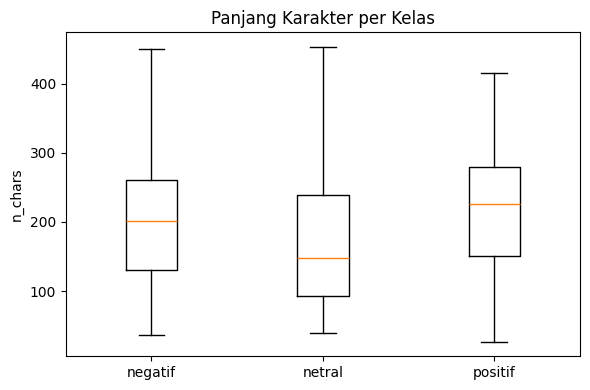

C:\Users\LEGION\AppData\Local\Temp\ipykernel_21696\3640690505.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)


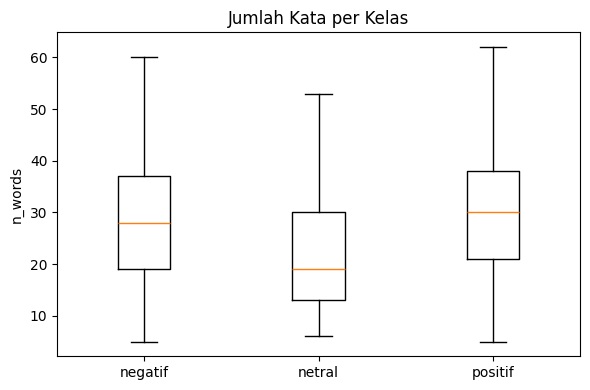

In [54]:
for col, title in [("n_chars","Panjang Karakter per Kelas"),
                   ("n_words","Jumlah Kata per Kelas")]:
    plt.figure(figsize=(6,4))
    data = [df.loc[df["sentimen"]==k, col] for k in sorted(df["sentimen"].unique())]
    plt.boxplot(data, labels=sorted(df["sentimen"].unique()), showfliers=False)
    plt.title(title)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

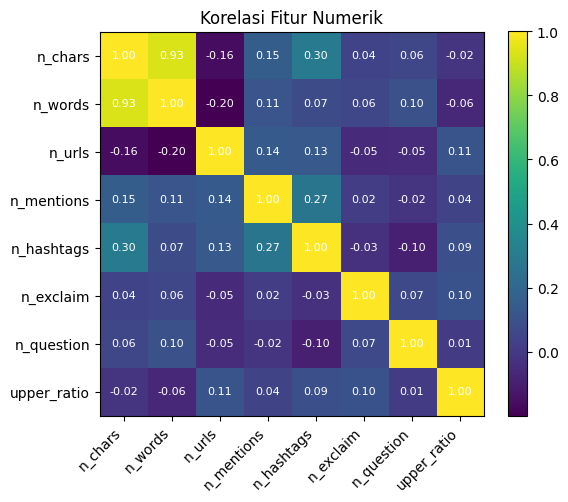

In [55]:
# Visual: heatmap korelasi fitur numerik
corr_num = df[agg_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr_num, interpolation="nearest")
plt.title("Korelasi Fitur Numerik")
plt.xticks(range(len(agg_cols)), agg_cols, rotation=45, ha="right")
plt.yticks(range(len(agg_cols)), agg_cols)
for i in range(len(agg_cols)):
    for j in range(len(agg_cols)):
        plt.text(j, i, f"{corr_num.values[i,j]:.2f}", ha="center", va="center", color="w", fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()

n_question tinggi pada negatif, n_urls/n_hashtags cenderung tinggi pada netral, n_chars/n_words lebih tinggi pada positif. Korelasi moderat antara n_chars dan n_words; fitur lain relatif saling melengkapi, sehingga baik digabungkan dengan TF-IDF

In [56]:
df

,sentimen,tweet,tweet_pp,n_chars,n_words,n_urls,n_mentions,n_hashtags,n_exclaim,n_question,upper_ratio
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata USER indonesia tidak dihargai bangsa asin...,119,20,1,1,0,1,2,0.030769
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","batuan langka, tasbih jokowi hadiah dari habib...",75,11,1,0,0,0,1,0.139785
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","di era jokowi, ekonomi indonesia semakin baik....",176,14,0,0,1,0,0,0.103175
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","bagi sumatra selatan, asian games berdampak pa...",129,17,0,0,0,1,0,0.054688
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara kita berutang buat bangun infrastruktur...,252,34,0,0,0,0,0,0.008197
...,...,...,...,...,...,...,...,...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati selalu bangga dan mengedepank...,125,17,0,0,1,0,0,0.030303
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,1. harus ceramah di damai indonesiaku 2. perek...,93,12,0,0,1,0,0,0.125000
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dengan mendukung perekonomi...,94,14,1,0,0,1,0,0.047297
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa bersama pak ...,66,10,1,0,0,1,0,0.066116


In [62]:
df.to_csv('data_processed.csv', index=False, encoding="utf-8-sig")